In [1]:
#-- IMPORTING MODULES --
import numpy as np
import mpmath as mp

import math
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.optimize import fsolve
import scipy.misc
from scipy.misc import derivative
import scipy.interpolate
from scipy.interpolate import griddata
from scipy.integrate import quad, trapz, cumtrapz, romberg, fixed_quad, odeint, ode
from scipy import linalg
from numpy.linalg import inv
from scipy.special import gamma, hyp1f1
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator

#Atropy cosmology modules
import astropy.units as astrou
from astropy.cosmology import Planck18_arXiv_v2 as cosmo
from astropy.cosmology import z_at_value

# Import mycode
import sys
path = '/Users/feixu/OneDrive - The University of Chicago/Documents/Research'
sys.path.append(path+'/mycode/')
sys.path.append(path+'/lensingFei/')
import constantfei 
from detector_snr_fei import *
from optical_depthfei import *
from RBBH_fei import *
import sensitivity_curves as sc


#Plotting
from matplotlib.ticker import ScalarFormatter
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fontSz = 15
fontsz = 13
fontssz = 11

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

#Export results folder
import sys
dir_base=sys.path[0]
dir_out1=dir_base+"/plots_py_gw_lensing/"
dir_out2=dir_base+"/fits_py_gw_lensing/"

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


         	Approximation will be used...
4.551812916295461


/Users/feixu/OneDrive - The University of Chicago/Documents/Research/GW_len/github/RBBH_fei.py:73: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  normmchirp = integrate.quad(lambda x: mchirpspl(x), Mchirpmin, Mchirpmax)[0]
/Users/feixu/OneDrive - The University of Chicago/Documents/Research/GW_len/github/RBBH_fei.py:84: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determin

* ### Read in 2d PDF for $M_{chirp}$ and q (mass ratio) 

In [2]:
# Read in Mchirp, q distribution generated from ITM (See P(Mchirp, q) 2D interpolation.ipynb)
hdul = fits.open(dir_out2+'Pchirpq_2Dfei.fits')
data1 = hdul[1].data
mchirp_2d = data1['mchirp_2d']
qratio_2d = data1['qratio_2d']
pdf_2d = data1['pdf_2d']

# Interpolate to get the 2D function
def Pchirpq_2d(mchirp, qratio):
    spl = interpolate.interp2d(mchirp_2d, qratio_2d, pdf_2d, kind='linear')
    return spl(mchirp, qratio)

Pchirpq_2d = np.vectorize(Pchirpq_2d)

* ### Read in $P(\mu)$ of the Primary image & Secondary image

In [3]:
sigma_starm = 161e3
mu_min = 1e-2; mu_max = 1e2

In [4]:
hdul = fits.open(dir_out2+'Pmu1_fitting.fits')
data1 = hdul[1].data
mu_1st = data1['mul']
Pmu_1stl = data1['Pmu1_fitting(mul)']

spl_Pmu1 = interpolate.interp1d(mu_1st, Pmu_1stl, kind = 'linear', fill_value = 'extrapolate')

def Pmu_1st(mu0):
    
    if (mu0 < np.max(mu_1st) and mu0>np.min(mu_1st)):
        value = spl_Pmu1(mu0)
    else:
        value = 0.
    
    return value

Pmu_1st = np.vectorize(Pmu_1st)

In [5]:
hdul = fits.open(dir_out2+'Pmu2_fitting.fits')
data1 = hdul[1].data
mu_2nd = data1['mul']
Pmu_2ndl = data1['Pmu2_fitting(mul)']

spl_Pmu2 = interpolate.interp1d(mu_2nd, Pmu_2ndl, kind = 'linear', fill_value = 'extrapolate')

def Pmu_2nd(mu0):
    
    if (mu0 < np.max(mu_2nd) and mu0>np.min(mu_2nd)):
        value = spl_Pmu2(mu0)
    else:
        value = 0.
    
    return value

Pmu_2nd = np.vectorize(Pmu_2nd)

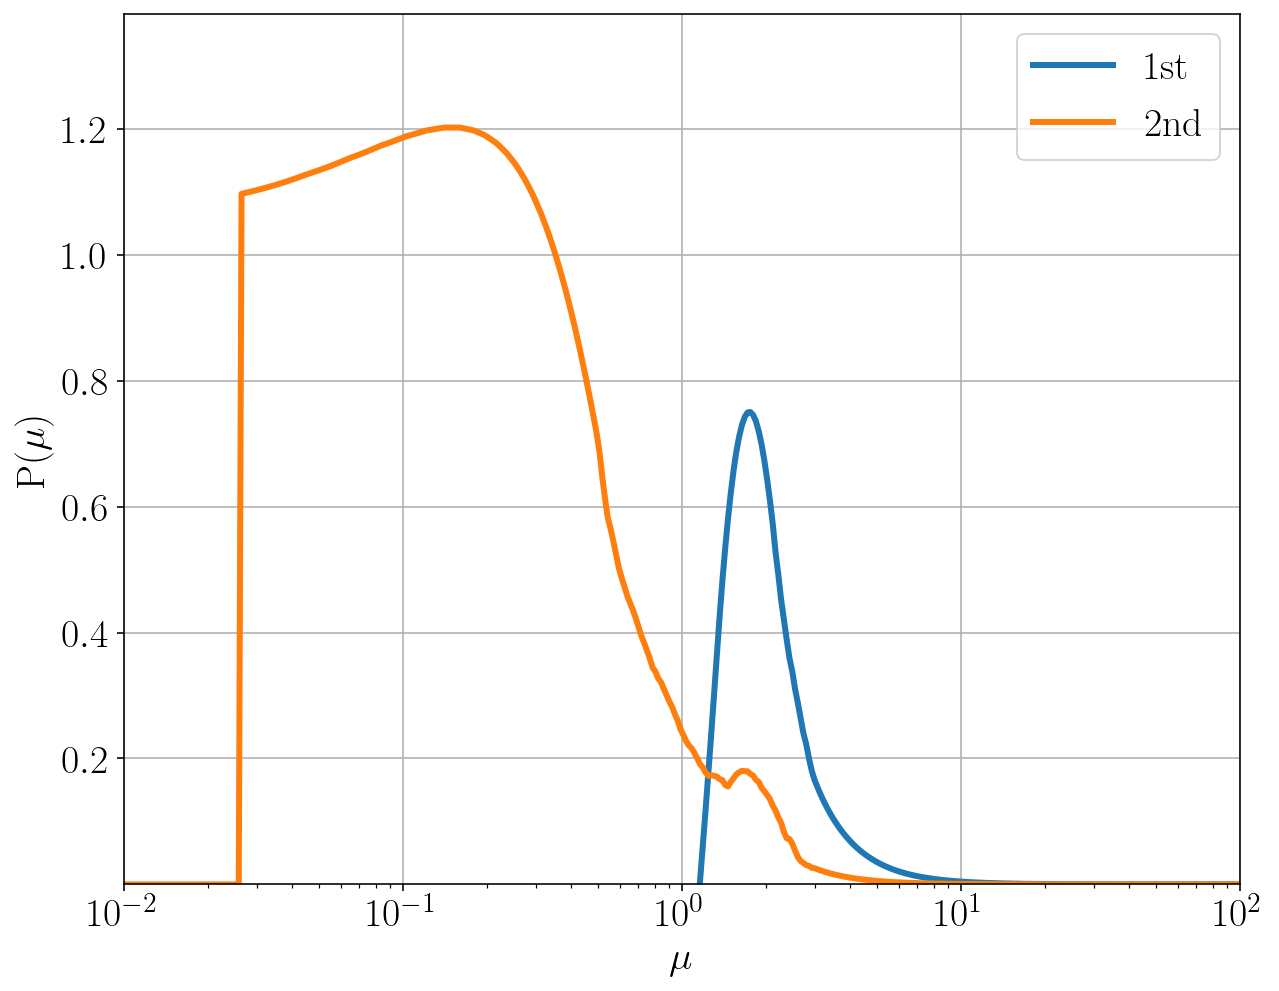

In [6]:
plt.figure(figsize=(10, 8))

mul = np.logspace(-3, 2, num=500)

plt.plot(mul, Pmu_1st(mul), linewidth = 3, label='1st')
plt.plot(mul, Pmu_2nd(mul), linewidth = 3, label='2nd')

plt.xlabel(r'$\mu$', fontsize=20)
plt.ylabel(r'P($\mu$)', fontsize=20)

plt.xticks(size=20)
plt.yticks(size=20)

plt.xscale('log')
#plt.yscale('log')

plt.xlim(1e-2, 1e2)
plt.ylim(1e-3)

plt.legend(fontsize=20)
plt.grid(True)

* ### Read in pre-caculated SNR and detection fraction without including magnification bias 
See Paper_Lensing_event_rate_paper_correctMchirpq_test_2D_xxx.ipynb

In [9]:
hdul = fits.open(dir_out2+'fractz_aplus.fits')
data1 = hdul[1].data
zl_aplus = data1['zl_aplus']
rhooptl_aplus = data1['rhooptl_aplus'] # signal to noise ratio
fractz_aplus = data1['fractz_aplus'] # P(mchirp, q)*P_det(rho(z, Mchirp, q))
MCHIRPL_aplus = data1['MCHIRPL']
QRATIOL_aplus = data1['QRATIOL']

mchirpl = np.linspace(1, 50., num=90); 
qratiol = np.linspace(0, 1., num=80); 
mul = np.linspace(mu_min, mu_max, num=90)

ZL, MCHIRPL, QRATIOL, MUL = np.meshgrid(zl_aplus, mchirpl, qratiol, mul, indexing='ij', sparse=True)


In [10]:
def rhoopt_find_aplus(z0, mchirp, qratio):
    ind0x = np.where(z0 == zl_aplus)
    ind0y = np.where((MCHIRPL_aplus == mchirp)*(QRATIOL_aplus == qratio))
    return rhooptl_aplus[ind0x][0][ind0y][0]
rhoopt_find_aplus = np.vectorize(rhoopt_find_aplus)

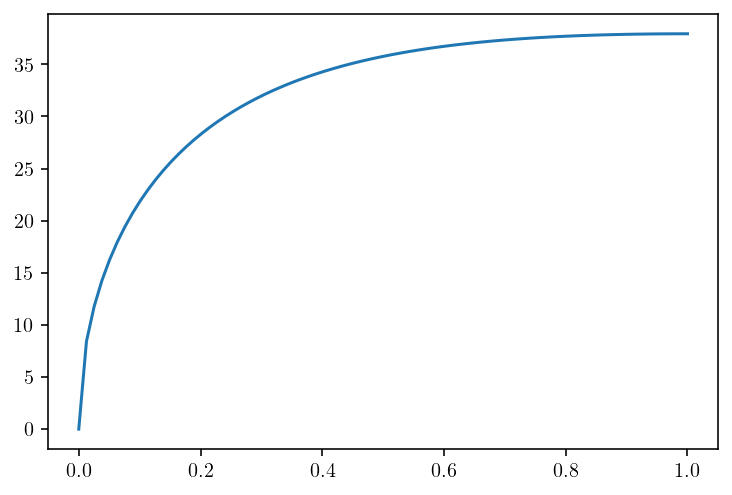

In [16]:
plt.plot(qratiol, rhoopt_find_aplus(zl_aplus[10], mchirpl[30], qratiol))

In [35]:
zl_aplus[59], qratiol[8]

(1.4936708860759493, 0.10126582278481013)

/Users/feixu/OneDrive - The University of Chicago/Documents/Research/GW_len/Untitled Folder/detector_sensitivity_correct.py:188: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 2*C*np.sqrt(scipy.integrate.quad(lambda f: (1/Sh_aplus(f)**2)*((f/f_merg)**(-7/3)), f_low, f_ISCO)[0])
/Users/feixu/OneDrive - The University of Chicago/Documents/Research/GW_len/Untitled Folder/detector_sensitivity_correct.py:188: RuntimeWarning: invalid value encountered in sqrt
  return 2*C*np.sqrt(scipy.integrate.quad(lambda f: (1/Sh_aplus(f)**2)*((f/f_merg)**(-7/3)), f_low, f_ISCO)[0])


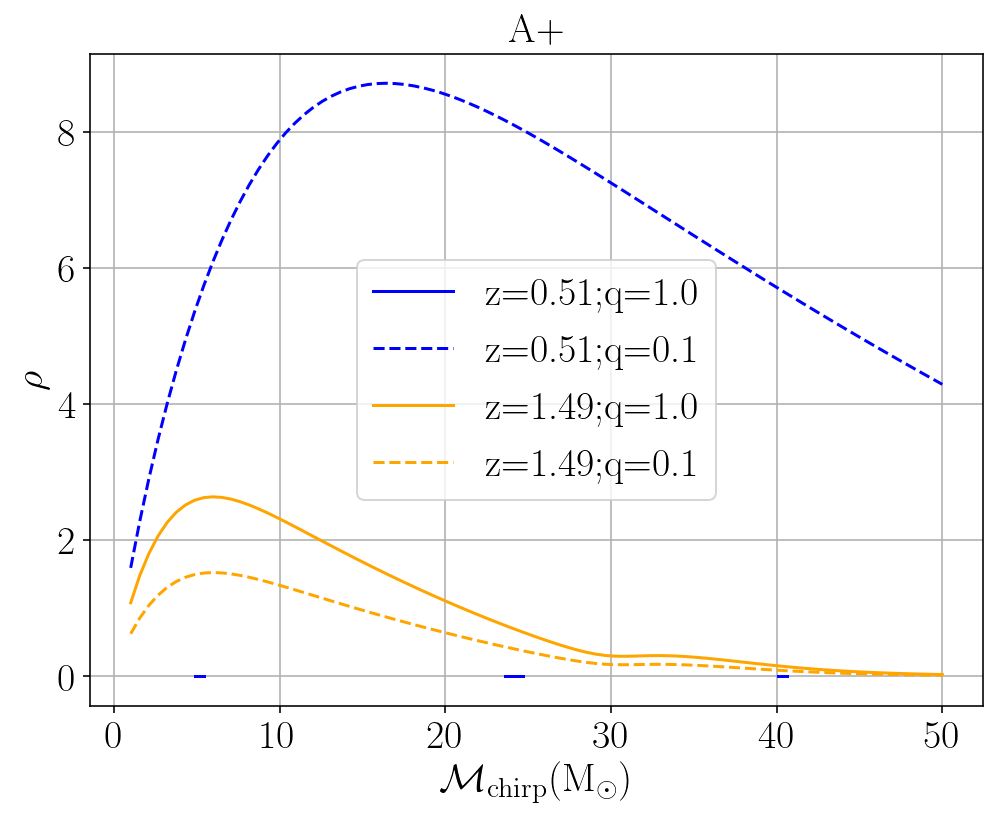

In [54]:
plt.figure(figsize=(8, 6))
plt.plot(mchirpl, rho_opt_aplus(zl_aplus[20], mchirpl, qratiol[-1]), color='blue', \
         label='z='+str(round(zl_aplus[20], 2))+';'+'q='+str(round(qratiol[-1], 2)))
plt.plot(mchirpl, rhoopt_find_aplus(zl_aplus[20], mchirpl, qratiol[8]), '--', color='blue', \
        label='z='+str(round(zl_aplus[20], 2))+';'+'q='+str(round(qratiol[8], 2)))

plt.plot(mchirpl, rhoopt_find_aplus(zl_aplus[59], mchirpl, qratiol[-1]), color='orange', \
         label='z='+str(round(zl_aplus[59], 2))+';'+'q='+str(round(qratiol[-1], 2)))
plt.plot(mchirpl, rhoopt_find_aplus(zl_aplus[59], mchirpl, qratiol[8]), '--', color='orange', \
         label='z='+str(round(zl_aplus[59], 2))+';'+'q='+str(round(qratiol[8], 2)))

plt.legend(fontsize=20)

plt.xlabel(r'$\rm \mathcal{M}_{chirp} (M_\odot)$', fontsize=20)
plt.ylabel(r'$\rho$', fontsize=20)
plt.title(r'A+', fontsize=20)

plt.xticks(size=20)
plt.yticks(size=20)

plt.grid(True)



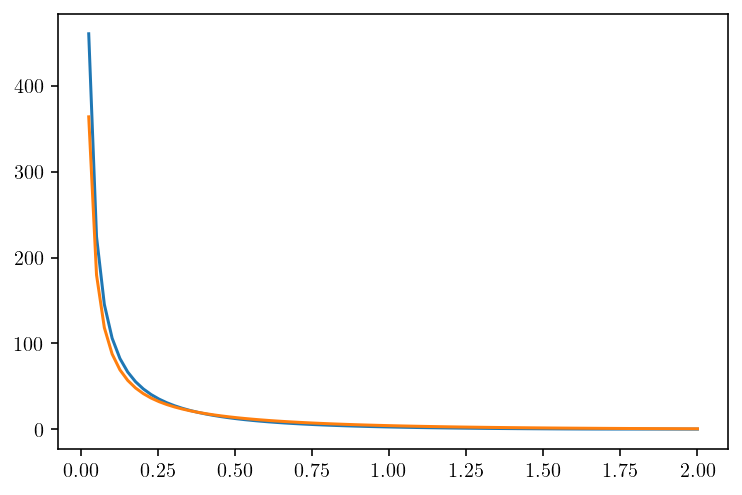

In [14]:
plt.plot(zl_aplus, rhoopt_find_aplus(zl_aplus, mchirpl[45], qratiol[30]))
plt.plot(zl_aplus, rhoopt_find_aplus(zl_aplus, mchirpl[25], qratiol[30]))

### Calculate grid for detection fraction including magnification $p_\text{det}(z, \mathcal{M}, q, \mu) = \ p(\mathcal{M}, q)\cdot P(\frac{\rho_\text{thr}}{\sqrt \mu \rho_\text{opt}(\mathcal{M}, q, z)})\$,


### on a grid of $z, \mathcal{M}, q, \mu$

In [8]:
# Calculate grid for detection fraction including magnification
start = time.time()
TEMP0 = rhoopt_find_aplus(ZL, MCHIRPL, QRATIOL)
end = time.time()
print(end-start)
TEMP = Pchirpq_2d(MCHIRPL, QRATIOL)*Pmu_2nd(MUL)*P_detect(np.sqrt(MUL)*TEMP0)
TEMP[np.where(np.isnan)] = 0.
end = time.time()
print(end-start)


23.416732788085938
43.81159496307373


### MC integration $I = \int_{\Omega} f(\bar{x}) d\bar{x}$, Integration volume: $V = \int_{\Omega} d\bar{x}$
### We sample points uniformly in $\Omega: \bar{x}_1, \bar{x}_2,..., \bar{x}_N$
$I = \frac{V}{N}\sum_{i=1}^{N} f(\bar{x}_i) = <f> V$
### The integration variance: $Var(f) = \sigma_N^2 = \frac{1}{N-1}\sum_{i=1}^N (f(\bar{x})-<f>)^2$

In [20]:
# Monte Carlo integration
def Monte_Carlo_intfei(fun, var, varrange):
    # varrange is the range of the variables [[xmin, xmax], [ymin, ymax], [zmin, zmax]]
    # var contains the randomly generated variables [[x1,...,xn], [y1,...,yn], [z1,...,zn]]
    V = np.prod(abs(varrange[:,1]-varrange[:,0]))
    fx_rand = fun(*var)
    N = len(var[0])
    fx_expect = np.sum(fx_rand)/N
    #print(np.where(np.isnan(fx_rand)))
    value = V*fx_expect
    var = np.sum((fx_rand-fx_expect)**2)/(N-1)
    return value, var

* ### Calculate detection fraction
first interpolate within the grid at each redshift (mchirp, qratio, mu)
then integrate within the grid using MC integration method

In [10]:
fractzl_mag2_aplus = []
for i in range(len(zl_aplus)): 
    
    #z0 = zl_aplus[i]
    
    start = time.time()
    
    f = RegularGridInterpolator((mchirpl, qratiol, mul), TEMP[i], bounds_error = False, fill_value = None)
    def f1(mchirp0, qratio0, mu0):
        #print(mchirp0, qratio0, mu0)
        return f(np.array([mchirp0, qratio0, mu0]))
    
    f1 = np.vectorize(f1)
    
    n_rand = 50000
    #print(f1(np.random.uniform(1., 50., n_rand), np.random.uniform(0., 1., n_rand), np.random.uniform(mu_min, mu_max, n_rand)))
    
    #end = time.time()
    #print(end-start)
    
    fractzl_mag2_aplus.append(Monte_Carlo_intfei(f1, np.array([np.random.uniform(1., 50., n_rand), \
                                    np.random.uniform(0., 1., n_rand), \
                                    np.random.uniform(mu_min, mu_max, n_rand)]), \
                           np.array([[1., 50.], [0., 1.], [mu_min, mu_max]])))
    
    print(fractzl_mag2_aplus[-1])
    end = time.time()
    print(end-start)
    

(0.0, 0.0)
8.231192827224731
(1.0230616039570744, 5.9549455438002465e-05)
8.169360160827637
(0.9801320676727084, 4.859397381974084e-05)
8.08262586593628
(0.8775017557137235, 3.256949362683204e-05)
8.218659162521362
(0.7813457533891442, 2.2507060505137e-05)
8.306064128875732
(0.7062898163061476, 1.5524626942611493e-05)
8.191482067108154
(0.6168631811186307, 1.0861126860000432e-05)
8.87281584739685
(0.5451712361746378, 7.537857821737049e-06)
9.153482913970947
(0.469927346246304, 5.202038343422674e-06)
9.210780143737793
(0.41043063867246954, 3.7270937253124902e-06)
9.098358154296875
(0.3760074660282287, 2.7843303181053402e-06)
9.091876983642578
(0.32252213992831597, 1.9898277785523457e-06)
9.08050012588501
(0.27998182699368696, 1.4475251667336656e-06)
9.144318103790283
(0.24333535676232035, 1.0197852034845439e-06)
9.272866010665894
(0.21278358488586596, 7.497351333704771e-07)
9.945677757263184
(0.1815839882360121, 5.250681840791573e-07)
9.684470891952515
(0.16587835760500344, 4.0618769945

In [11]:
fractzl_mag2_aplus = np.array(fractzl_mag2_aplus)

* ### Save it 

In [12]:
t = Table([zl_aplus, rhooptl_aplus, fractz_aplus, fractzl_mag2_aplus], \
              names=['zl_aplus', 'rhooptl_aplus', 'fractz_aplus', 'fractzl_mag2_aplus'], masked=True)
t.write(dir_out2+'fractz_mag2_aplus.fits', format='fits', overwrite=True) 


In [19]:
np.sqrt(5.9549455438002465e-05)/1.0230616039570744

0.007542878487933075